In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class TableResNet(nn.Module):
    def __init__(self, input_dim, num_classes=1, pretrained=False):
        super(TableResNet, self).__init__()
        # ResNet18のロード
        self.resnet = resnet18(pretrained=pretrained)
        # conv1をテーブルデータに適応
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # 出力層の変更
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return torch.sigmoid(x)


学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)

    # ResNetモデルのインスタンス化
    model = TableResNet(input_dim=X_train.shape[1], num_classes=1, pretrained=False).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    num_epochs = 100
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1).unsqueeze(2)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # 検証データの評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early stoppingの条件
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標としてMCCを計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc


In [12]:
device_id = 1  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:59:05,911] A new study created in memory with name: no-name-41f46cc4-a9fb-4639-be7d-392d02a6b06e
/tmp/ipykernel_317998/1959338376.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/tmp/ipykernel_317998/1959338376.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gonken/

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

Epoch [1/100], Loss: 0.6020
Epoch [1/100], Train Loss: 0.6020, Val Loss: 0.5581
Epoch [2/100], Loss: 0.5777
Epoch [2/100], Train Loss: 0.5777, Val Loss: 0.5606
Epoch [3/100], Loss: 0.5753
Epoch [3/100], Train Loss: 0.5753, Val Loss: 0.5607
Epoch [4/100], Loss: 0.5785
Epoch [4/100], Train Loss: 0.5785, Val Loss: 0.5540
Epoch [5/100], Loss: 0.5724
Epoch [5/100], Train Loss: 0.5724, Val Loss: 0.5591
Epoch [6/100], Loss: 0.5682
Epoch [6/100], Train Loss: 0.5682, Val Loss: 0.5656
Epoch [7/100], Loss: 0.5611
Epoch [7/100], Train Loss: 0.5611, Val Loss: 0.5679
Epoch [8/100], Loss: 0.5734
Epoch [8/100], Train Loss: 0.5734, Val Loss: 0.5786
Epoch [9/100], Loss: 0.5812
Epoch [9/100], Train Loss: 0.5812, Val Loss: 0.5581
Epoch [10/100], Loss: 0.5679
Epoch [10/100], Train Loss: 0.5679, Val Loss: 0.5663
Epoch [11/100], Loss: 0.5671
Epoch [11/100], Train Loss: 0.5671, Val Loss: 0.5519
Epoch [12/100], Loss: 0.5643
Epoch [12/100], Train Loss: 0.5643, Val Loss: 0.5512
Epoch [13/100], Loss: 0.5589
Epoch

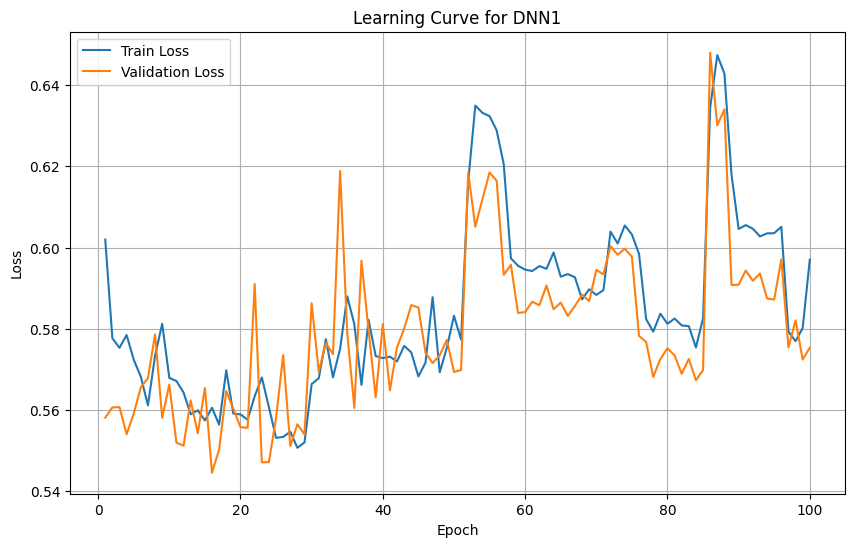

In [ ]:
best_params=study.best_params
model = TableResNet(input_dim=X_train_tensor.shape[1],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.39%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


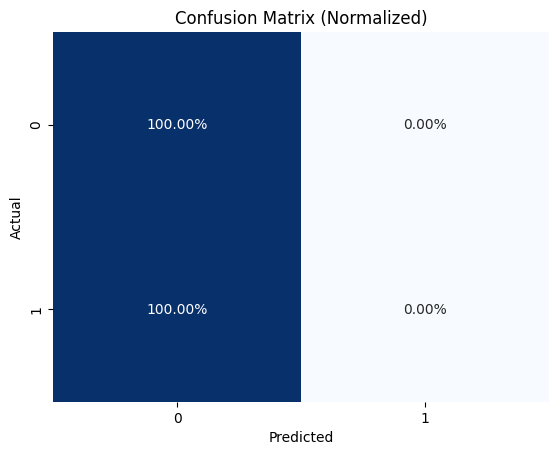

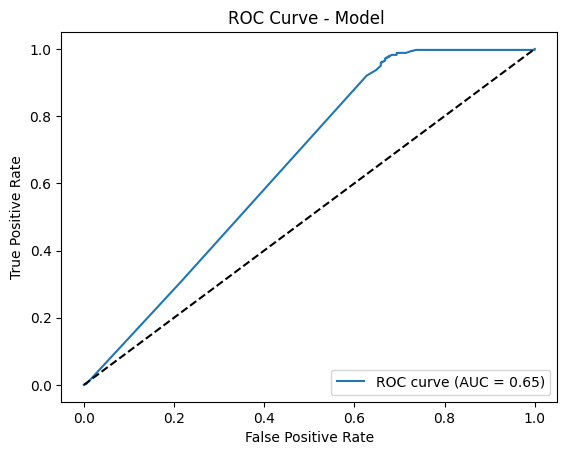

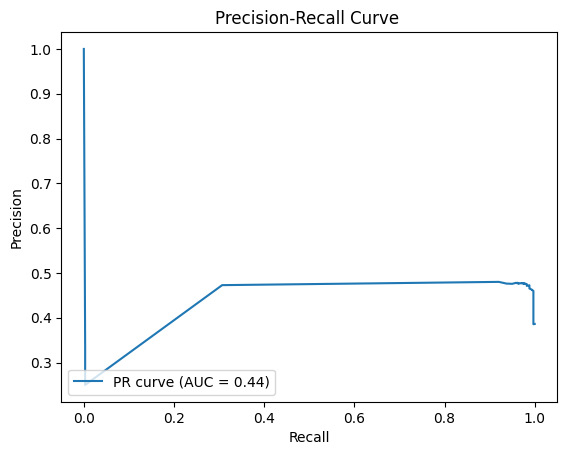

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [ ]:
# モデルと構造を保存
torch.save(model, '../../saved_model/FT_transformer_2.pth')
